In [1]:
import os
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:
sys.path.append("../../src/.")
import plotting_functions as pf

In [3]:
DIR = "../../data/"
SUBWAYUS = "Subway USA/subway_usa_"

In [4]:
train_df = pd.read_csv(DIR + SUBWAYUS + "processed_train.csv", index_col="store")
test_df = pd.read_csv(DIR + SUBWAYUS + "processed_test.csv", index_col="store")

In [5]:
train_df.shape

(12944, 114)

In [6]:
result_df = pd.DataFrame([], index=train_df.index)

In [7]:
def get_cluster_scores(df, labels):
    sil = silhouette_score(df, labels)
    cali = calinski_harabasz_score(df, labels)
    davi = davies_bouldin_score(df, labels)
    score_record = {
        "silhouette_score": sil,
        "calinski_harabasz_score": cali,
        "davies_bouldin_score": davi
    }
    print(f"Silhouette score: {sil} \n Calinski Harabasz score: {cali} \n Davies Bouldin Score: {davi}")
    return score_record

## PCA

### Test for Mininum Components to Capture 90% Variance

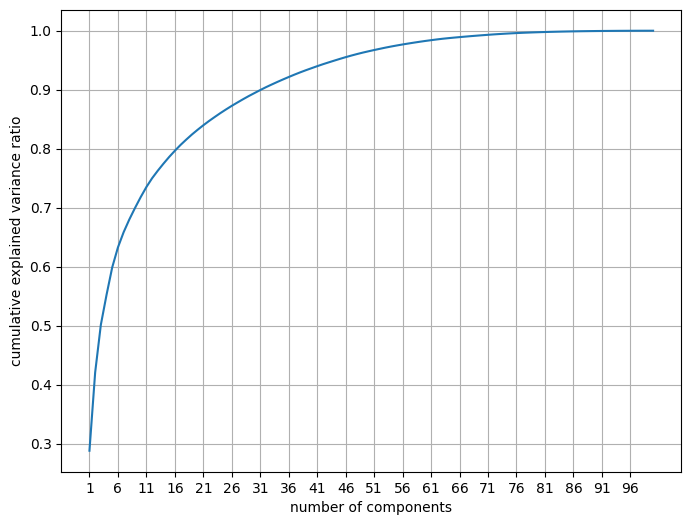

32

In [8]:
pf.pca_plot(train_df)

### PCA model (90% Variance) - Layer 1

In [9]:
pca_1 = PCA(n_components=32, whiten=True, random_state=42)
pca_1.fit(train_df)

PCA(n_components=32, random_state=42, whiten=True)

#### Filter and Count Important Features (of heavy weights)

Filter the values in the PCA component matrix, and count the occurrence of the features in the filtered matrix.

In [10]:
W = abs(pca_1.components_)
features = train_df.columns
long_results = []
for i in range(W.shape[0]):
    array = W[i]
    heavy_idx = np.where(array > 0.1)
    long_results += list(features[heavy_idx])

In [11]:
count = pd.Series(long_results).value_counts()
pca_features = count.index.tolist()
count

com0811_p_ta                         19
market_size                          19
nces_private_schools_nearest_dist    17
dtpop_students_p_ta                  14
inrix_total_ta                       14
                                     ..
disposable_inc_avg_ta                 1
avg_faminc_ta                         1
banks_5mi                             1
hh_inc_gt_75k_p_ta                    1
hhinc100pl_p_ta                       1
Name: count, Length: 114, dtype: int64

In [12]:
weighted_W = pca_1.explained_variance_ratio_ * W.T
pca_feature_weight = pd.Series(np.sum(weighted_W, axis=1), index=train_df.columns.tolist())
pca_feature_weight = pca_feature_weight.filter(items=pca_features, axis=0)
pca_feature_weight.sort_values(ascending=False, inplace=True)
pca_feature_weight

market_size                         0.161836
store_density                       0.086469
empcy_ta                            0.077021
hu_ownerocc_ta                      0.076535
daypop_dens_ta                      0.076274
                                      ...   
wealth_hhavg_ta                     0.052256
dtpop_unemployed_p_ta               0.051602
nces_public_schools_nearest_dist    0.051530
occ_bc_p_ta                         0.050706
popgr10cn_ta                        0.048290
Length: 114, dtype: float64

In [13]:
reduced_train = train_df[pca_feature_weight.index]
reduced_test = test_df[pca_feature_weight.index]


In [14]:
def corr_pair(target_corr, corr_threshold=0.7):
    np.fill_diagonal(target_corr.values, 0)
    sorted_pair = target_corr.abs().unstack().sort_values(kind="quicksort", ascending=False)
    return sorted_pair[sorted_pair > corr_threshold]

correlated_pairs = corr_pair(reduced_train.corr())

In [15]:
correlated_pairs[::2]

wealth_hhtotal_ta      hhcy_ta                                      1.000000
occhu_ta               wealth_hhtotal_ta                            1.000000
                       hhcy_ta                                      1.000000
spend_lunch_ta         spend_breakfastbrunch_ta                     0.999520
                       spend_dinner_ta                              0.999293
                                                                      ...   
hrsa_hospitals_5mi     nces_private_schools_total_enrollment_5mi    0.701566
spend_foodbev_ta       nces_public_schools_total_enrollment_1mi     0.701449
spend_lunch_ta         nces_public_schools_total_enrollment_1mi     0.700531
hrsa_hospitals_5mi     nces_public_schools_total_enrollment_5mi     0.700436
places_of_worship_1mi  nces_private_schools_5mi                     0.700153
Length: 362, dtype: float64

In [16]:
from collections import Counter

def corr_pair_drop(feature_pairs, corr_with_target):
    selected, discarded = Counter(), Counter()
    final_discarded = []
    for f1, f2 in feature_pairs:
        if abs(corr_with_target[f1]) < abs(corr_with_target[f2]):
            selected[f2] += 1
            discarded[f1] += 1
        else:
            selected[f1] += 1
            discarded[f2] += 1
    for key, count in discarded.items():
        if key not in selected:
            final_discarded.append(key)
        elif discarded[key] >= selected[key]:
            final_discarded.append(key)
    return final_discarded


In [17]:
corr_drop_list = corr_pair_drop(correlated_pairs.index, pca_feature_weight)

In [18]:
reduced_train.drop(columns=corr_drop_list, inplace=True)
reduced_test.drop(columns=corr_drop_list, inplace=True)

/var/folders/t1/c4fmzstn5v92jwsl8z5vhpp40000gn/T/ipykernel_10883/1625573170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_train.drop(columns=corr_drop_list, inplace=True)
/var/folders/t1/c4fmzstn5v92jwsl8z5vhpp40000gn/T/ipykernel_10883/1625573170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_test.drop(columns=corr_drop_list, inplace=True)


In [19]:
correlated_pairs = corr_pair(reduced_train.corr())
correlated_pairs[:20]

spend_foodbev_ta                          spend_breakfastbrunch_ta                    0.997999
spend_breakfastbrunch_ta                  spend_foodbev_ta                            0.997999
                                          popcy_ta                                    0.984816
popcy_ta                                  spend_breakfastbrunch_ta                    0.984816
                                          spend_foodbev_ta                            0.981934
spend_foodbev_ta                          popcy_ta                                    0.981934
nces_public_schools_5mi                   nces_public_schools_total_enrollment_5mi    0.977263
nces_public_schools_total_enrollment_5mi  nces_public_schools_5mi                     0.977263
hhinc150pl_p_ta                           disposable_inc_avg_ta                       0.976828
disposable_inc_avg_ta                     hhinc150pl_p_ta                             0.976828
avghhinc_ta                               hhinc150

In [20]:
corr_drop_list = [
    "hhgrpycy_ta", "popcy_ta",
    "nces_public_schools_5mi",
    "hhinc150pl_p_ta", "avghhinc_ta", "avg_faminc_ta", "hh_inc_gt_500k_p_ta",
    "dtpop_ta", "empcy_ta",
    "ipeds_postsecondary_schools_1mi",
    "ipeds_postsecondary_schools_5mi", 
    "nces_public_schools_1mi",
    "nces_public_schools_total_enrollment_5mi", 
    "nces_private_schools_total_enrollment_5mi",
    "percapita_inc_ta", "spend_breakfastbrunch_ta",
    "nces_public_schools_total_enrollment_1mi",
]

In [21]:
reduced_train.drop(columns=corr_drop_list, inplace=True)
reduced_test.drop(columns=corr_drop_list, inplace=True)

/var/folders/t1/c4fmzstn5v92jwsl8z5vhpp40000gn/T/ipykernel_10883/1625573170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_train.drop(columns=corr_drop_list, inplace=True)
/var/folders/t1/c4fmzstn5v92jwsl8z5vhpp40000gn/T/ipykernel_10883/1625573170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_test.drop(columns=corr_drop_list, inplace=True)


In [22]:
correlated_pairs = corr_pair(reduced_train.corr())
correlated_pairs

banks_5mi                          hrsa_number_of_certified_beds_5mi    0.880359
hrsa_number_of_certified_beds_5mi  banks_5mi                            0.880359
edu_bachplus_p_ta                  disposable_inc_avg_ta                0.800920
disposable_inc_avg_ta              edu_bachplus_p_ta                    0.800920
spend_foodbev_ta                   hu_ownerocc_ta                       0.786859
hu_ownerocc_ta                     spend_foodbev_ta                     0.786859
emp_p_ta                           dtpop_students_9th_12th_p_ta         0.752531
dtpop_students_9th_12th_p_ta       emp_p_ta                             0.752531
daypop_dens_ta                     banks_5mi                            0.751306
banks_5mi                          daypop_dens_ta                       0.751306
spend_foodbev_ta                   banks_5mi                            0.704225
banks_5mi                          spend_foodbev_ta                     0.704225
dtype: float64

In [23]:
reduced_train.columns

Index(['market_size', 'store_density', 'hu_ownerocc_ta', 'daypop_dens_ta',
       'edu_bachplus_p_ta', 'hh_expected_vehicle_ta', 'genx_p_ta',
       'dmm_gla_5mi', 'white_p_ta', 'emp_p_ta',
       'hrsa_number_of_certified_beds_5mi', 'age65pl_p_ta', 'hu_vacant_ta',
       'dmm_nearest_dist', 'banks_5mi', 'dtpop_students_9th_12th_p_ta',
       'spend_foodbev_ta', 'dtpop_homemakers_p_ta', 'com12pl_p_ta',
       'pop_transient_ta', 'nces_private_schools_total_enrollment_1mi',
       'mortgage_avgrisk_ta',
       'ipeds_postsecondary_schools_total_enrollment_1mi',
       'hrsa_number_of_certified_beds_1mi', 'com0811_p_ta', 'pop_migration_ta',
       'ipeds_postsecondary_nearest_dist', 'pop_seasonal_ta',
       'nces_private_schools_nearest_dist', 'asian_p_ta', 'inrix_total_ta',
       'millenial_p_ta', 'com0002_p_ta', 'osm_nearest_exit_dist',
       'dmm_count_1mi', 'black_p_ta', 'medsalcy_ta', 'transitstops',
       'disposable_inc_avg_ta', 'hhgrfypy_ta', 'genz_p_ta',
       'transitstop_

In [24]:
manual_drop_list = [
    "hrsa_number_of_certified_beds_5mi",
    "hu_ownerocc_ta",
    "dtpop_students_9th_12th_p_ta",
    "daypop_dens_ta",
    "spend_foodbev_ta",    
]

In [25]:
reduced_train.drop(columns=manual_drop_list, inplace=True)
reduced_test.drop(columns=manual_drop_list, inplace=True)

/var/folders/t1/c4fmzstn5v92jwsl8z5vhpp40000gn/T/ipykernel_10883/3574851112.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_train.drop(columns=manual_drop_list, inplace=True)
/var/folders/t1/c4fmzstn5v92jwsl8z5vhpp40000gn/T/ipykernel_10883/3574851112.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_test.drop(columns=manual_drop_list, inplace=True)


In [26]:
reduced_train.columns.tolist()

['market_size',
 'store_density',
 'edu_bachplus_p_ta',
 'hh_expected_vehicle_ta',
 'genx_p_ta',
 'dmm_gla_5mi',
 'white_p_ta',
 'emp_p_ta',
 'age65pl_p_ta',
 'hu_vacant_ta',
 'dmm_nearest_dist',
 'banks_5mi',
 'dtpop_homemakers_p_ta',
 'com12pl_p_ta',
 'pop_transient_ta',
 'nces_private_schools_total_enrollment_1mi',
 'mortgage_avgrisk_ta',
 'ipeds_postsecondary_schools_total_enrollment_1mi',
 'hrsa_number_of_certified_beds_1mi',
 'com0811_p_ta',
 'pop_migration_ta',
 'ipeds_postsecondary_nearest_dist',
 'pop_seasonal_ta',
 'nces_private_schools_nearest_dist',
 'asian_p_ta',
 'inrix_total_ta',
 'millenial_p_ta',
 'com0002_p_ta',
 'osm_nearest_exit_dist',
 'dmm_count_1mi',
 'black_p_ta',
 'medsalcy_ta',
 'transitstops',
 'disposable_inc_avg_ta',
 'hhgrfypy_ta',
 'genz_p_ta',
 'transitstop_nearest_dist',
 'crime_total_index_ta',
 'hrsa_hospitals_nearest_dist',
 'osm_highway_exits_count_1mi',
 'com0508_p_ta',
 'dtpop_students_p_ta',
 'gq_college_p_ta',
 'dtpop_work_at_home_p_ta',
 'hh_ex

## Hierachical Clustering

In [27]:
from scipy.cluster.hierarchy import (
    average,
    complete,
    fcluster,
    single,
    ward,
)

---
### complete linkage with reduced data

In [28]:
reduced_linkage_array = complete(reduced_train)
reduced_hier_labels = fcluster(reduced_linkage_array, 8, criterion="maxclust") 

In [29]:
result_df['complet with reduced'] = reduced_hier_labels

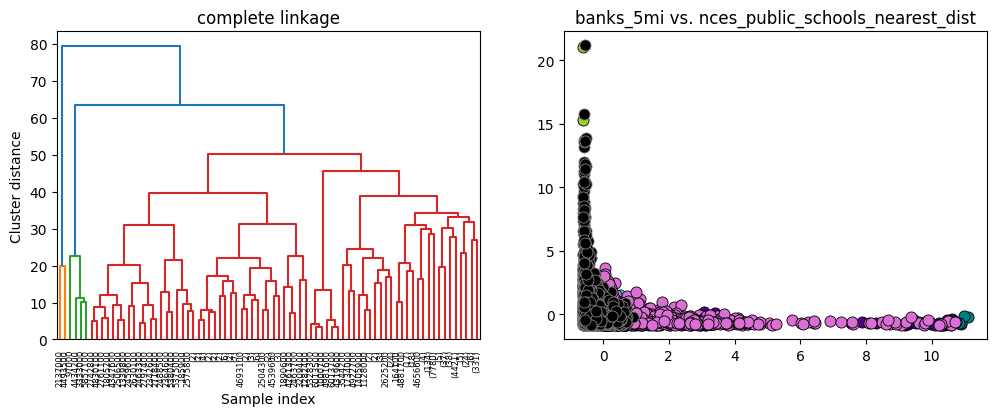

In [30]:
pf.plot_dendrogram_clusters(
    reduced_train, 
    reduced_linkage_array, 
    reduced_hier_labels, 
    p=8, 
    linkage_type='complete', 
    axis_0="banks_5mi",
    axis_1="nces_public_schools_nearest_dist",
    title="banks_5mi vs. nces_public_schools_nearest_dist"
)

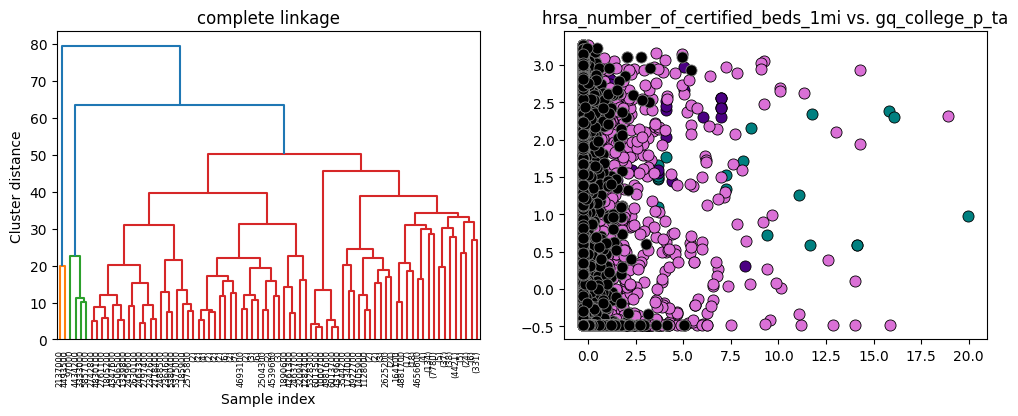

In [31]:
pf.plot_dendrogram_clusters(
    reduced_train, 
    reduced_linkage_array, 
    reduced_hier_labels, 
    p=8, 
    linkage_type='complete', 
    axis_0="hrsa_number_of_certified_beds_1mi",
    axis_1="gq_college_p_ta",
    title="hrsa_number_of_certified_beds_1mi vs. gq_college_p_ta"
)

In [32]:
unique, counts = np.unique(reduced_hier_labels, return_counts=True)
dict(zip(unique, counts))

{1: 2, 2: 4, 3: 21, 4: 51, 5: 6, 6: 37, 7: 7956, 8: 4867}

In [33]:
get_cluster_scores(reduced_train, reduced_hier_labels)

Silhouette score: 0.11545740167546194 
 Calinski Harabasz score: 423.7609370704268 
 Davies Bouldin Score: 1.3468985820349402


{'silhouette_score': 0.11545740167546194,
 'calinski_harabasz_score': 423.7609370704268,
 'davies_bouldin_score': 1.3468985820349402}

---
### ward linkage with reduced data

In [34]:
reduced_linkage_array = ward(reduced_train)
reduced_hier_labels = fcluster(reduced_linkage_array, 3, criterion="maxclust") 

In [35]:
silhouette_score(reduced_train, reduced_hier_labels)

0.06870510370703285

In [36]:
davies_bouldin_score(reduced_train, reduced_hier_labels)

2.8160182197404953

In [37]:
calinski_harabasz_score(reduced_train, reduced_hier_labels)

1230.6799687237813

In [38]:
result_df['ward with reduced'] = reduced_hier_labels

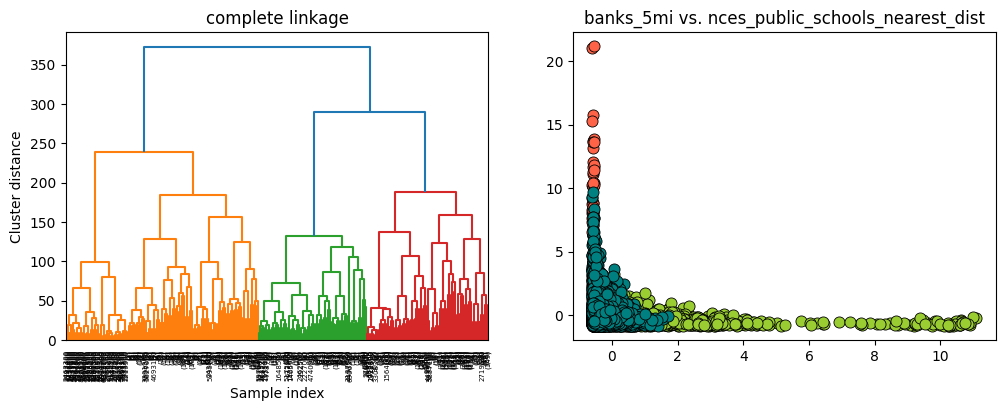

In [39]:
pf.plot_dendrogram_clusters(
    reduced_train, 
    reduced_linkage_array, 
    reduced_hier_labels, 
    p=8, 
    linkage_type='complete', 
    axis_0="banks_5mi",
    axis_1="nces_public_schools_nearest_dist",
    title="banks_5mi vs. nces_public_schools_nearest_dist"
)

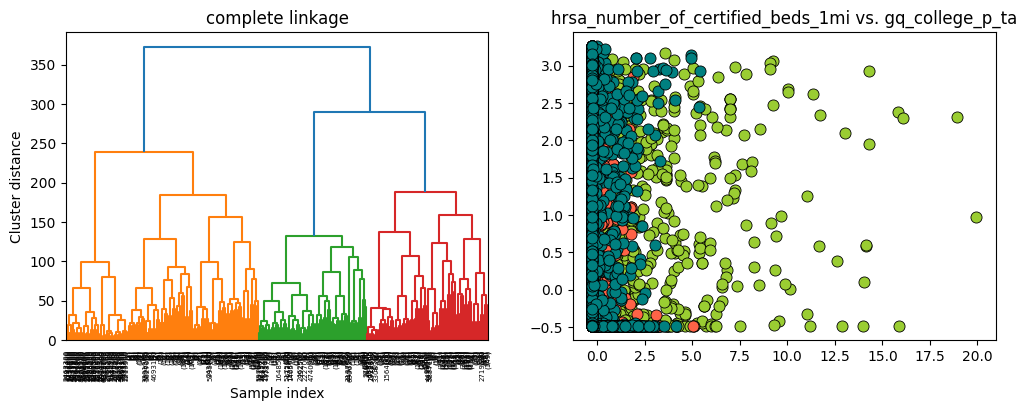

In [40]:
pf.plot_dendrogram_clusters(
    reduced_train, 
    reduced_linkage_array, 
    reduced_hier_labels, 
    p=8, 
    linkage_type='complete', 
    axis_0="hrsa_number_of_certified_beds_1mi",
    axis_1="gq_college_p_ta",
    title="hrsa_number_of_certified_beds_1mi vs. gq_college_p_ta"
)

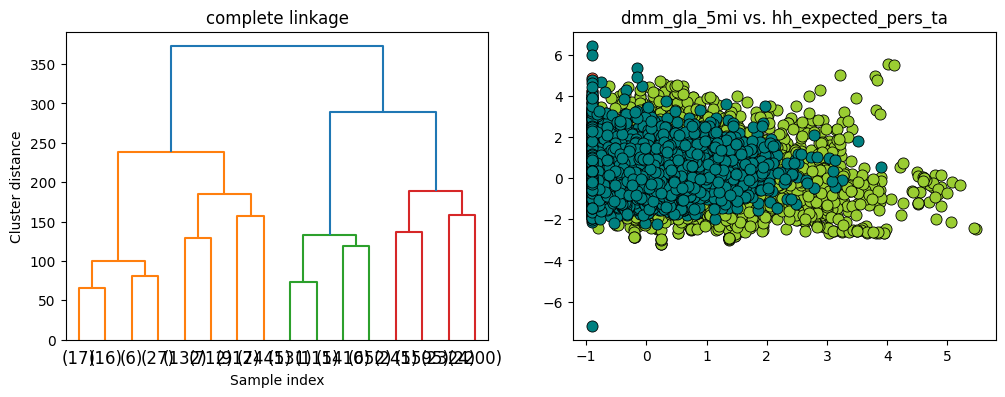

In [41]:
pf.plot_dendrogram_clusters(
    reduced_train, 
    reduced_linkage_array, 
    reduced_hier_labels, 
    p=3, 
    linkage_type='complete', 
    axis_0="dmm_gla_5mi",
    axis_1="hh_expected_pers_ta",
    title="dmm_gla_5mi vs. hh_expected_pers_ta"
)

In [42]:
unique, counts = np.unique(reduced_hier_labels, return_counts=True)
dict(zip(unique, counts))

{1: 4272, 2: 2308, 3: 6364}

In [43]:
get_cluster_scores(reduced_train, reduced_hier_labels)

Silhouette score: 0.06870510370703285 
 Calinski Harabasz score: 1230.6799687237813 
 Davies Bouldin Score: 2.8160182197404953


{'silhouette_score': 0.06870510370703285,
 'calinski_harabasz_score': 1230.6799687237813,
 'davies_bouldin_score': 2.8160182197404953}

In [44]:
result_df.head()

,complet with reduced,ward with reduced
store,,
6150300,8,1
3784100,7,3
1192500,7,3
449400,8,2
2292700,7,1
